# Batch Normalization
## PyTorch Implementation

Author: Bingchen Wang

Last updated: 25 Nov, 2022

## Contents

- [Load the packages and inspect the data](#LPID)
- [Model without Batch Norm](#MwoBN)
- [Model with Batch Norm](#MwBN)
- [Train the models](#Training)
- [Understand Batch Norm](#Understanding)

<a name = "LPID"></a>
## Load the packages and inspect the data

In [1]:
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [2]:
cancer_data = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer_data.data, cancer_data.target, test_size = 0.1, random_state = 10000)
feature_names = cancer_data.feature_names
label_names = cancer_data.target_names
print('Shape of the training set:', X_train.shape)
print('Shape of the test set:', X_test.shape)

Shape of the training set: (512, 30)
Shape of the test set: (57, 30)


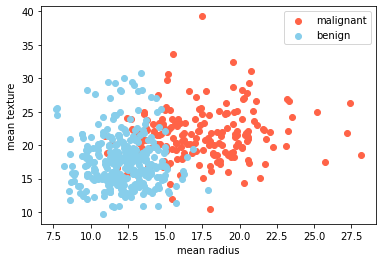

In [3]:
plt.scatter(X_train[y_train == 0,0], X_train[y_train == 0,1], label = label_names[0], c = 'tomato')
plt.scatter(X_train[y_train == 1,0], X_train[y_train == 1,1], label = label_names[1], c = 'skyblue')
plt.legend()
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.show()

In [4]:
train_dataloader = DataLoader(TensorDataset(torch.from_numpy(X_train),torch.from_numpy(y_train.reshape(-1,1))), batch_size = 64, shuffle = True)
test_dataloader = DataLoader(TensorDataset(torch.from_numpy(X_test),torch.from_numpy(y_test.reshape(-1,1))), batch_size = 1, shuffle = True)

<a name = 'MwoBN'></a>
## Model without Batch Norm

In [5]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.linear_relu_layers = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        y_pred  = self.linear_relu_layers(x)
        return y_pred

In [6]:
model_withoutBN = NN()
print(model_withoutBN)

NN(
  (linear_relu_layers): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


<a name = 'MwBN'></a>
## Model with Batch Norm

In [7]:
class NN_BN(nn.Module):
    def __init__(self):
        super(NN_BN, self).__init__()
        self.linear_relu_layers = nn.Sequential(
            nn.Linear(2, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        y_pred  = self.linear_relu_layers(x)
        return y_pred

In [8]:
model_withBN = NN_BN()
print(model_withBN)

NN_BN(
  (linear_relu_layers): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=16, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


<a name = 'Training'></a>
## Train the models

In [9]:
def train(train_dataloader, model, lr, loss_fn, epochs, scheduler = None, optimizer = 'Adam'):
    # for tracking purpose
    size = len(train_dataloader.dataset)
    batch_loss_log = []
    batch_accuracy_log = []
    epoch_loss_log = []
    epoch_accuracy_log = []
    if optimizer == 'SGD':
        optimizer = torch.optim.SGD(params = model.parameters(), lr = learning_rate)
    if optimizer == 'Adam':
        optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)
    if scheduler is not None:
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    for epoch in range(epochs):
        #print(f'Current epoch: [{epoch+1:>3d}/{epochs:>3d}]')
        
        for batch, (X, y) in enumerate(train_dataloader):
            y_pred = model(X[:,:2].float()).float()
            loss = loss_fn(y_pred, y.float())
            accuracy = 1 - torch.mean((y_pred>=0.5)*(1-y.float()) + (y_pred<0.5)*y.float())

            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_loss_log.append(loss.item())
            batch_accuracy_log.append(accuracy.item())
            #print(f'\rCurrent loss: {loss:>6f}, accuracy: {accuracy:>4f} [{(batch+1)*64}/{size}]', end = '')
        if scheduler is not None:
            scheduler.step()
        epoch_loss_log.append(loss.item())
        epoch_accuracy_log.append(accuracy.item())
        
        if (epoch+1)% (epochs//10) ==0:
            print(f'Epoch {epoch+1} final loss: {loss:>6f}, final accuracy: {accuracy:>4f}')
            print(f'Current learning rate: {optimizer.param_groups[0]["lr"]:6f}')
    print('Training completed.')
    
    return batch_loss_log, batch_accuracy_log, epoch_loss_log, epoch_accuracy_log

In [10]:
torch.manual_seed(0)
learning_rate = 1e-3
batch_size = 64
epochs = 200
loss_fn = nn.BCELoss()

batch_loss_log1, batch_accuracy_log1, epoch_loss_log1, epoch_accuracy_log1 = train(train_dataloader, model_withoutBN, learning_rate, loss_fn, epochs, scheduler = True, optimizer = 'Adam')

Epoch 20 final loss: 0.619929, final accuracy: 0.687500
Current learning rate: 0.000818
Epoch 40 final loss: 0.509886, final accuracy: 0.781250
Current learning rate: 0.000669
Epoch 60 final loss: 0.367471, final accuracy: 0.859375
Current learning rate: 0.000547
Epoch 80 final loss: 0.378028, final accuracy: 0.859375
Current learning rate: 0.000448
Epoch 100 final loss: 0.295914, final accuracy: 0.921875
Current learning rate: 0.000366
Epoch 120 final loss: 0.265130, final accuracy: 0.859375
Current learning rate: 0.000299
Epoch 140 final loss: 0.210746, final accuracy: 0.937500
Current learning rate: 0.000245
Epoch 160 final loss: 0.250183, final accuracy: 0.875000
Current learning rate: 0.000200
Epoch 180 final loss: 0.259515, final accuracy: 0.890625
Current learning rate: 0.000164
Epoch 200 final loss: 0.249215, final accuracy: 0.890625
Current learning rate: 0.000134
Training completed.


In [11]:
torch.manual_seed(0)
learning_rate = 1e-3
batch_size = 64
epochs = 200
loss_fn = nn.BCELoss()

batch_loss_log2, batch_accuracy_log2, epoch_loss_log2, epoch_accuracy_log2 = train(train_dataloader, model_withBN, learning_rate, loss_fn, epochs, scheduler = True, optimizer = 'Adam')

Epoch 20 final loss: 0.275556, final accuracy: 0.859375
Current learning rate: 0.000818
Epoch 40 final loss: 0.214395, final accuracy: 0.937500
Current learning rate: 0.000669
Epoch 60 final loss: 0.242140, final accuracy: 0.890625
Current learning rate: 0.000547
Epoch 80 final loss: 0.283874, final accuracy: 0.859375
Current learning rate: 0.000448
Epoch 100 final loss: 0.233711, final accuracy: 0.906250
Current learning rate: 0.000366
Epoch 120 final loss: 0.293700, final accuracy: 0.843750
Current learning rate: 0.000299
Epoch 140 final loss: 0.190913, final accuracy: 0.921875
Current learning rate: 0.000245
Epoch 160 final loss: 0.233855, final accuracy: 0.890625
Current learning rate: 0.000200
Epoch 180 final loss: 0.279220, final accuracy: 0.875000
Current learning rate: 0.000164
Epoch 200 final loss: 0.268176, final accuracy: 0.875000
Current learning rate: 0.000134
Training completed.


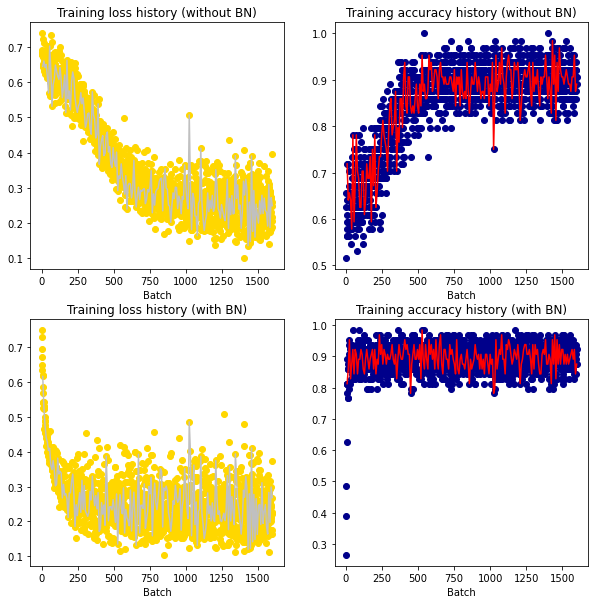

In [12]:
fig, ax = plt.subplots(2,2, figsize = (10,10))

ax[0,0].scatter(range(1,len(batch_loss_log1)+1), batch_loss_log1, c = 'gold')
ax[0,0].plot(np.arange(1,len(epoch_loss_log1)+1)*8, epoch_loss_log1, c = 'silver')
ax[0,0].set_title('Training loss history (without BN)')
ax[0,0].set_xlabel('Batch')
ax[0,1].scatter(range(1,len(batch_accuracy_log1)+1), batch_accuracy_log1, c = 'darkblue')
ax[0,1].plot(np.arange(1,len(epoch_accuracy_log1)+1)*8, epoch_accuracy_log1, c = 'red')
ax[0,1].set_title('Training accuracy history (without BN)')
ax[0,1].set_xlabel('Batch')

ax[1,0].scatter(range(1,len(batch_loss_log2)+1), batch_loss_log2, c = 'gold')
ax[1,0].plot(np.arange(1,len(epoch_loss_log2)+1)*8, epoch_loss_log2, c = 'silver')
ax[1,0].set_title('Training loss history (with BN)')
ax[1,0].set_xlabel('Batch')
ax[1,1].scatter(range(1,len(batch_accuracy_log2)+1), batch_accuracy_log2, c = 'darkblue')
ax[1,1].plot(np.arange(1,len(epoch_accuracy_log2)+1)*8, epoch_accuracy_log2, c = 'red')
ax[1,1].set_title('Training accuracy history (with BN)')
ax[1,1].set_xlabel('Batch')

plt.show()

The model with batch normalization trains much faster than the one without.

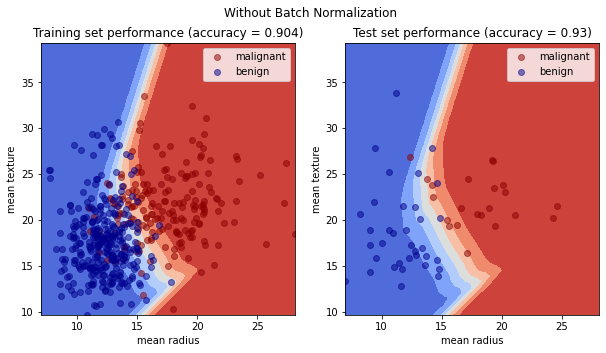

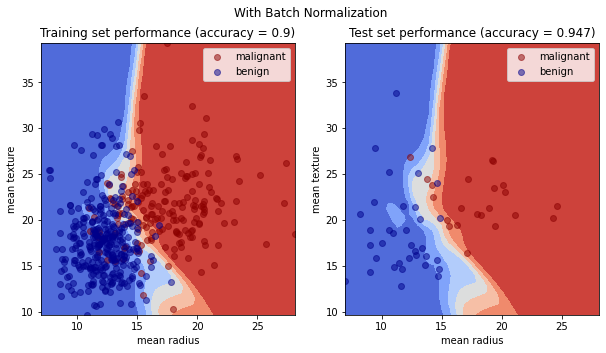

In [13]:
X1_min, X2_min = np.min(cancer_data.data[:,:2], axis = 0)
X1_max, X2_max = np.max(cancer_data.data[:,:2], axis = 0)
X1_span = np.linspace(X1_min, X1_max, 50)
X2_span = np.linspace(X2_min, X2_max, 50)
X1_space, X2_space = np.meshgrid(X1_span, X2_span)
#X_space = np.vstack((X_space[0].reshape(-1),X_space[1].reshape(-1))).transpose()
#leaves_space = tree1.apply(X_space)
#fit_space = tree1.predict(X_space)

fit_space = np.zeros(X1_space.shape)
fit_space2 = np.zeros(X1_space.shape)
d1, d2 = fit_space.shape

model_withoutBN.eval()
model_withBN.eval()
with torch.no_grad():
    for i in range(d1):
        for j in range(d2):
            fit_space[i,j] = model_withoutBN(torch.from_numpy(np.array([[X1_space[i,j],X2_space[i,j]]])).float())
            fit_space2[i,j] = model_withBN(torch.from_numpy(np.array([[X1_space[i,j],X2_space[i,j]]])).float())

fig, ax = plt.subplots(1,2, figsize = (10,5))

with torch.no_grad():
    train_pred = model_withoutBN(torch.from_numpy(X_train[:,:2]).float()) >= 0.5
    train_acc = 1 -  torch.mean(train_pred* (1 - y_train.reshape(-1,1)) + (1- train_pred*1.)*y_train.reshape(-1,1)).item()
    test_pred = model_withoutBN(torch.from_numpy(X_test[:,:2]).float()) >= 0.5
    test_acc =  1 - torch.mean(test_pred* (1 - y_test.reshape(-1,1)) + (1- test_pred*1.)*y_test.reshape(-1,1)).item()
    
ax[0].contourf(X1_space, X2_space, fit_space, cmap=cm.coolwarm_r)
ax[0].scatter(X_train[y_train == 0,0],X_train[y_train == 0,1], color = 'darkred', label = label_names[0], alpha = 0.5)
ax[0].scatter(X_train[y_train == 1,0], X_train[y_train == 1,1], color = 'darkblue', label = label_names[1], alpha = 0.5)
ax[0].legend()
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[1])
ax[0].set_title(f'Training set performance (accuracy = {round(train_acc,3)})')


ax[1].contourf(X1_space, X2_space, fit_space, cmap=cm.coolwarm_r)
ax[1].scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], color = 'darkred', label = label_names[0], alpha = 0.5)
ax[1].scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color = 'darkblue', label = label_names[1], alpha = 0.5)
ax[1].legend()
ax[1].set_xlabel(feature_names[0])
ax[1].set_ylabel(feature_names[1])
ax[1].set_title(f'Test set performance (accuracy = {round(test_acc,3)})')

fig.suptitle('Without Batch Normalization')
plt.show()

fig, ax = plt.subplots(1,2, figsize = (10,5))

with torch.no_grad():
    train_pred = model_withBN(torch.from_numpy(X_train[:,:2]).float()) >= 0.5
    train_acc = 1 -  torch.mean(train_pred* (1 - y_train.reshape(-1,1)) + (1- train_pred*1.)*y_train.reshape(-1,1)).item()
    test_pred = model_withBN(torch.from_numpy(X_test[:,:2]).float()) >= 0.5
    test_acc =  1 - torch.mean(test_pred* (1 - y_test.reshape(-1,1)) + (1- test_pred*1.)*y_test.reshape(-1,1)).item()
    
ax[0].contourf(X1_space, X2_space, fit_space2, cmap=cm.coolwarm_r)
ax[0].scatter(X_train[y_train == 0,0],X_train[y_train == 0,1], color = 'darkred', label = label_names[0], alpha = 0.5)
ax[0].scatter(X_train[y_train == 1,0], X_train[y_train == 1,1], color = 'darkblue', label = label_names[1], alpha = 0.5)
ax[0].legend()
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[1])
ax[0].set_title(f'Training set performance (accuracy = {round(train_acc,3)})')


ax[1].contourf(X1_space, X2_space, fit_space2, cmap=cm.coolwarm_r)
ax[1].scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], color = 'darkred', label = label_names[0], alpha = 0.5)
ax[1].scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color = 'darkblue', label = label_names[1], alpha = 0.5)
ax[1].legend()
ax[1].set_xlabel(feature_names[0])
ax[1].set_ylabel(feature_names[1])
ax[1].set_title(f'Test set performance (accuracy = {round(test_acc,3)})')

fig.suptitle('With Batch Normalization')
plt.show()

Note the regularization effect of batch normalization.

In [14]:
for name, param in model_withBN.named_parameters():
    print(name, param.data)

linear_relu_layers.0.weight tensor([[ 0.6169, -0.1863],
        [ 0.5152, -0.2406],
        [ 0.3497, -0.3865],
        [ 0.1848,  0.0275],
        [ 0.1890,  0.1274],
        [-0.1423, -0.3361],
        [ 0.4751,  0.4057],
        [-0.5674,  0.0771],
        [-0.3922, -0.2342],
        [-0.5814, -0.0641],
        [-0.3329, -0.3985],
        [-0.5307, -0.1964],
        [ 0.1031, -0.3768],
        [ 0.3307, -0.4761],
        [-0.0972,  0.4349],
        [-0.3446,  0.4106],
        [-0.3471,  0.6794],
        [-0.1415,  0.1118],
        [-0.2382, -0.6148],
        [-0.7318, -0.6628],
        [-0.4687, -0.0062],
        [-0.2315, -0.3797],
        [-0.4621,  0.1122],
        [ 0.5814, -0.1376],
        [-0.0244,  0.4404],
        [ 0.2064, -0.2566],
        [-0.2714, -0.4281],
        [ 0.6142, -0.2794],
        [ 0.3317, -0.3656],
        [ 0.7085, -0.5623],
        [ 0.0672,  0.6640],
        [ 0.2760,  0.3396],
        [ 0.4615,  0.3511],
        [-0.1733, -0.0532],
        [ 0.4212,  0

## Understand Batch Norm
Goal: build a model to understand how the outcomes of different batch normalization layers look like.

In [15]:
class BN(nn.Module):
    def __init__(self):
        super(BN, self).__init__()
        self.l1 = nn.Linear(2, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.a1 = nn.ReLU()
        self.l2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.a2 = nn.ReLU()
        self.l3 = nn.Linear(32, 16)
        self.bn3 = nn.BatchNorm1d(16)
        self.a3 = nn.ReLU()
        self.l4 = nn.Linear(16, 1)
        self.a4 = nn.Sigmoid()

    def forward(self, x):
        # Layer 1
        z1 = self.l1(x)
        tilde_z1 = self.bn1(z1)
        a1 = self.a1(tilde_z1)
        
        # Layer 2
        z2 =  self.l2(a1)
        tilde_z2 = self.bn2(z2)
        a2 = self.a2(tilde_z2)
        
        # Layer 3
        z3 = self.l3(a2)
        tilde_z3 = self.bn3(z3)
        a3 = self.a3(tilde_z3)
        
        # Layer 4
        z4 = self.l4(a3)
        y_pred = self.a4(z4)
        
        cache = (tilde_z1, tilde_z2, tilde_z3)
        return y_pred, cache

In [16]:
model_BN = BN()
print(model_BN)

BN(
  (l1): Linear(in_features=2, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (a1): ReLU()
  (l2): Linear(in_features=64, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (a2): ReLU()
  (l3): Linear(in_features=32, out_features=16, bias=True)
  (bn3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (a3): ReLU()
  (l4): Linear(in_features=16, out_features=1, bias=True)
  (a4): Sigmoid()
)


In [17]:
def train_BN(train_dataloader, model, lr, loss_fn, epochs, scheduler = None, optimizer = 'Adam'):
    # for tracking purpose
    size = len(train_dataloader.dataset)
    
    # logs
    batch_loss_log = []
    batch_accuracy_log = []
    epoch_loss_log = []
    epoch_accuracy_log = []
    tilde_z1_log = []
    tilde_z2_log = []
    tilde_z3_log = []
    
    if optimizer == 'SGD':
        optimizer = torch.optim.SGD(params = model.parameters(), lr = learning_rate)
    if optimizer == 'Adam':
        optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)
    if scheduler is not None:
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    for epoch in range(epochs):
        #print(f'Current epoch: [{epoch+1:>3d}/{epochs:>3d}]')
        
        for batch, (X, y) in enumerate(train_dataloader):
            y_pred, cache = model(X[:,:2].float())
            y_pred = y_pred.float()
            loss = loss_fn(y_pred, y.float())
            accuracy = 1 - torch.mean((y_pred>=0.5)*(1-y.float()) + (y_pred<0.5)*y.float())

            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_loss_log.append(loss.item())
            batch_accuracy_log.append(accuracy.item())
            
            model.eval()
            with torch.no_grad():
                _, (tilde_z1, tilde_z2, tilde_z3) = model(torch.from_numpy(X_train[:,:2]).float())
            tilde_z1_log.append(tilde_z1)
            tilde_z2_log.append(tilde_z2)
            tilde_z3_log.append(tilde_z3)
            
            model.train()
            
            #print(f'\rCurrent loss: {loss:>6f}, accuracy: {accuracy:>4f} [{(batch+1)*64}/{size}]', end = '')
        if scheduler is not None:
            scheduler.step()
        epoch_loss_log.append(loss.item())
        epoch_accuracy_log.append(accuracy.item())
        
        if (epoch+1)% (epochs//10) ==0:
            print(f'Epoch {epoch+1} final loss: {loss:>6f}, final accuracy: {accuracy:>4f}')
            print(f'Current learning rate: {optimizer.param_groups[0]["lr"]:6f}')
    print('Training completed.')
    
    return batch_loss_log, batch_accuracy_log, epoch_loss_log, epoch_accuracy_log, tilde_z1_log, tilde_z2_log, tilde_z3_log

In [18]:
torch.manual_seed(0)
learning_rate = 1e-3
batch_size = 64
epochs = 200
loss_fn = nn.BCELoss()

batch_loss_log3, batch_accuracy_log3, epoch_loss_log3, epoch_accuracy_log3, tilde_z1_log, tilde_z2_log, tilde_z3_log = train_BN(train_dataloader, model_BN, learning_rate, loss_fn, epochs, scheduler = True, optimizer = 'Adam')

Epoch 20 final loss: 0.270592, final accuracy: 0.890625
Current learning rate: 0.000818
Epoch 40 final loss: 0.227786, final accuracy: 0.937500
Current learning rate: 0.000669
Epoch 60 final loss: 0.239130, final accuracy: 0.890625
Current learning rate: 0.000547
Epoch 80 final loss: 0.294375, final accuracy: 0.859375
Current learning rate: 0.000448
Epoch 100 final loss: 0.234407, final accuracy: 0.921875
Current learning rate: 0.000366
Epoch 120 final loss: 0.297615, final accuracy: 0.843750
Current learning rate: 0.000299
Epoch 140 final loss: 0.194292, final accuracy: 0.921875
Current learning rate: 0.000245
Epoch 160 final loss: 0.228753, final accuracy: 0.921875
Current learning rate: 0.000200
Epoch 180 final loss: 0.284127, final accuracy: 0.875000
Current learning rate: 0.000164
Epoch 200 final loss: 0.281760, final accuracy: 0.890625
Current learning rate: 0.000134
Training completed.


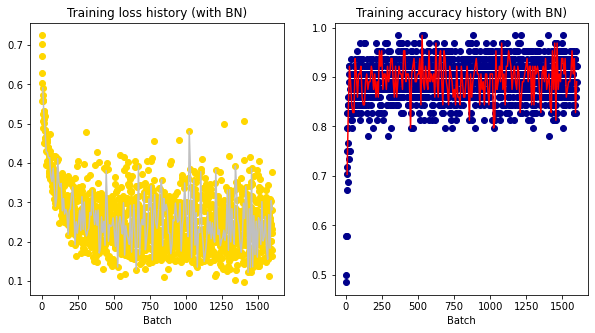

In [19]:
fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].scatter(range(1,len(batch_loss_log3)+1), batch_loss_log3, c = 'gold')
ax[0].plot(np.arange(1,len(epoch_loss_log3)+1)*8, epoch_loss_log3, c = 'silver')
ax[0].set_title('Training loss history (with BN)')
ax[0].set_xlabel('Batch')
ax[1].scatter(range(1,len(batch_accuracy_log3)+1), batch_accuracy_log3, c = 'darkblue')
ax[1].plot(np.arange(1,len(epoch_accuracy_log3)+1)*8, epoch_accuracy_log3, c = 'red')
ax[1].set_title('Training accuracy history (with BN)')
ax[1].set_xlabel('Batch')

plt.show()


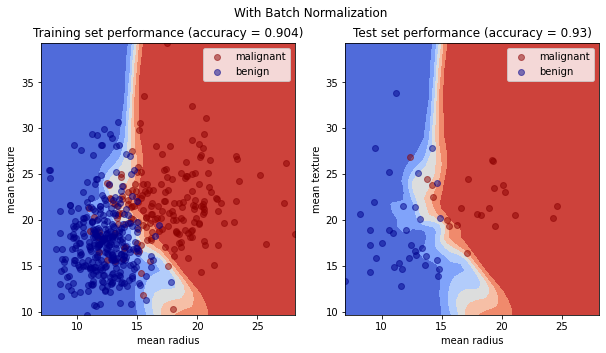

In [20]:
fit_space3 = np.zeros(X1_space.shape)

model_BN.eval()
with torch.no_grad():
    for i in range(d1):
        for j in range(d2):
            fit_space3[i,j], _ = model_BN(torch.from_numpy(np.array([[X1_space[i,j],X2_space[i,j]]])).float())
            
fig, ax = plt.subplots(1,2, figsize = (10,5))

with torch.no_grad():
    train_pred = model_BN(torch.from_numpy(X_train[:,:2]).float())[0] >= 0.5
    train_acc = 1 -  torch.mean(train_pred* (1 - y_train.reshape(-1,1)) + (1- train_pred*1.)*y_train.reshape(-1,1)).item()
    test_pred = model_BN(torch.from_numpy(X_test[:,:2]).float())[0] >= 0.5
    test_acc =  1 - torch.mean(test_pred* (1 - y_test.reshape(-1,1)) + (1- test_pred*1.)*y_test.reshape(-1,1)).item()
    
ax[0].contourf(X1_space, X2_space, fit_space3, cmap=cm.coolwarm_r)
ax[0].scatter(X_train[y_train == 0,0],X_train[y_train == 0,1], color = 'darkred', label = label_names[0], alpha = 0.5)
ax[0].scatter(X_train[y_train == 1,0], X_train[y_train == 1,1], color = 'darkblue', label = label_names[1], alpha = 0.5)
ax[0].legend()
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[1])
ax[0].set_title(f'Training set performance (accuracy = {round(train_acc,3)})')


ax[1].contourf(X1_space, X2_space, fit_space3, cmap=cm.coolwarm_r)
ax[1].scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], color = 'darkred', label = label_names[0], alpha = 0.5)
ax[1].scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color = 'darkblue', label = label_names[1], alpha = 0.5)
ax[1].legend()
ax[1].set_xlabel(feature_names[0])
ax[1].set_ylabel(feature_names[1])
ax[1].set_title(f'Test set performance (accuracy = {round(test_acc,3)})')

fig.suptitle('With Batch Normalization')
plt.show()

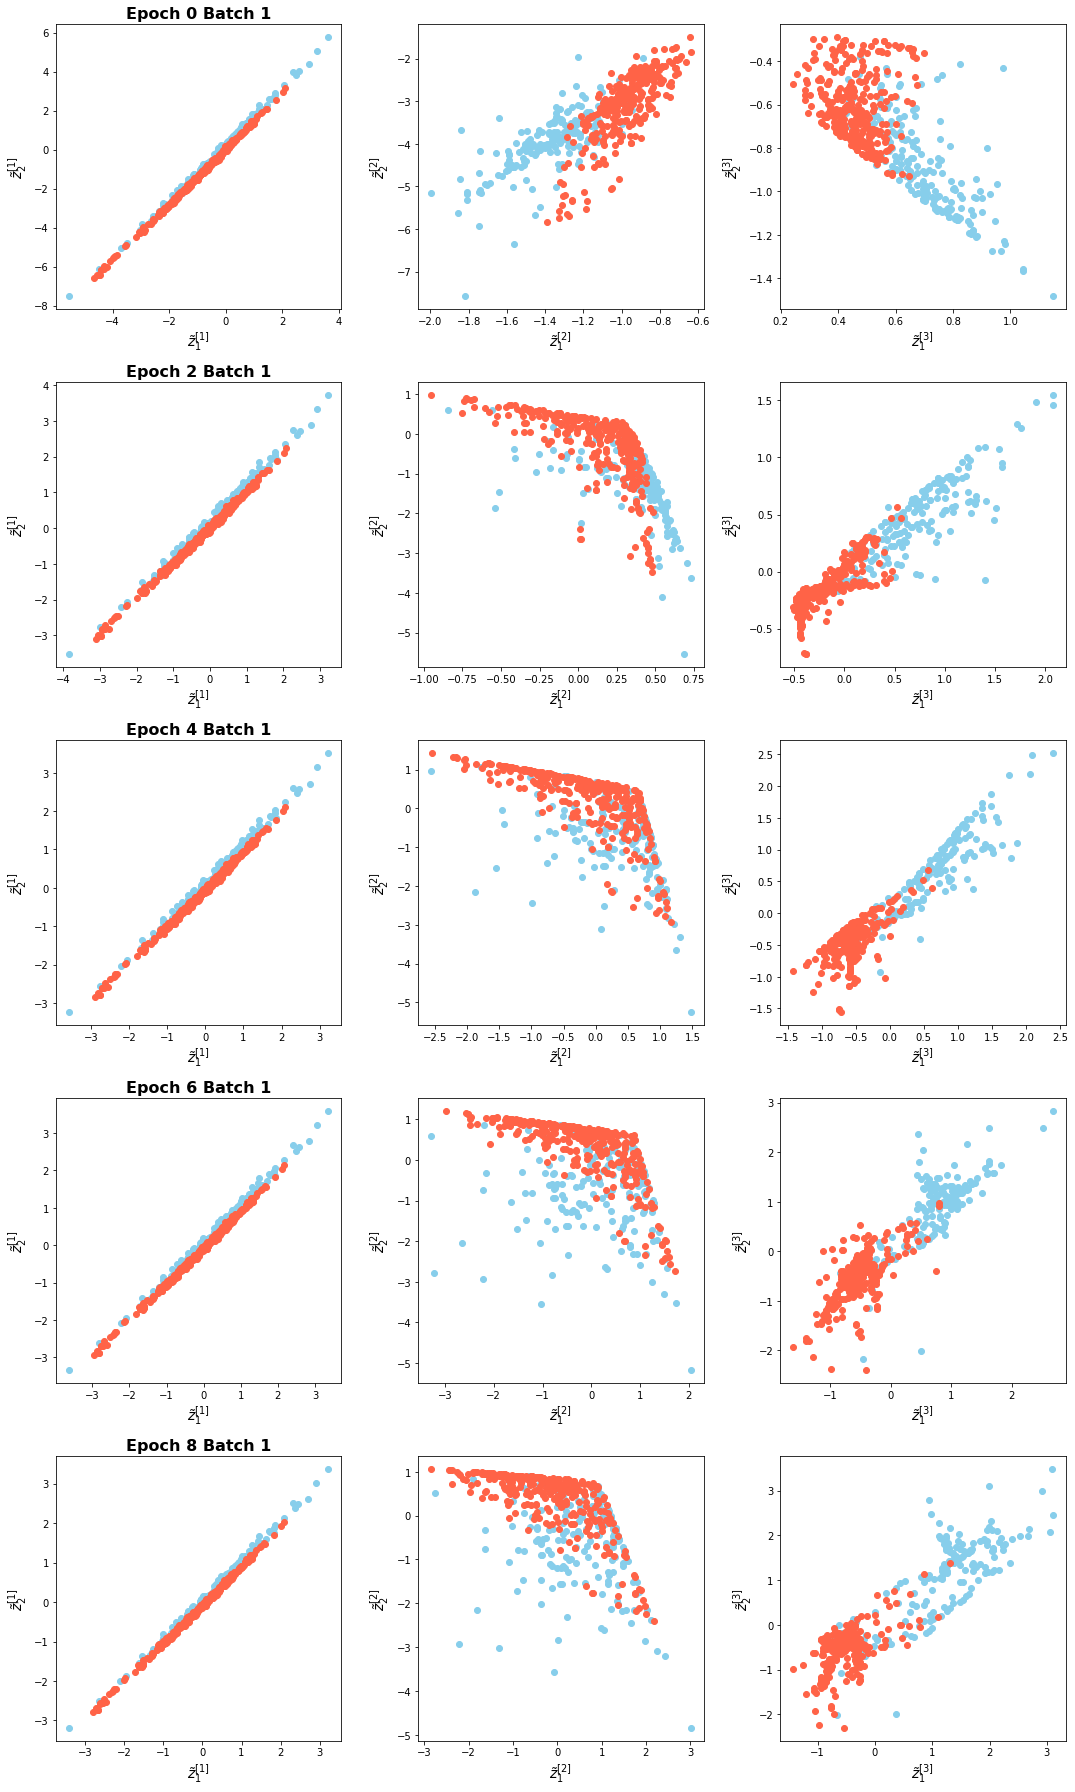

In [21]:
fig, ax = plt.subplots(5,3, figsize = (15,25))

for i in range(5):

    ax[i,0].scatter(tilde_z1_log[i*16][y_train == 0, 0], tilde_z1_log[i*16][y_train == 0, 1], color = 'skyblue')
    ax[i,0].scatter(tilde_z1_log[i*16][y_train == 1, 0], tilde_z1_log[i*16][y_train == 1, 1], color = 'tomato')
    ax[i,0].set_title(f'Epoch {i*2} Batch {1}', weight='bold', fontsize = 16)
    ax[i,0].set_xlabel(r'$\tilde z^{[1]}_1$', fontsize = 14)
    ax[i,0].set_ylabel(r'$\tilde z^{[1]}_2$', fontsize = 14)
    
    ax[i,1].scatter(tilde_z2_log[i*16][y_train == 0, 0], tilde_z2_log[i*16][y_train == 0, 1], color = 'skyblue')
    ax[i,1].scatter(tilde_z2_log[i*16][y_train == 1, 0], tilde_z2_log[i*16][y_train == 1, 1], color = 'tomato')
    ax[i,1].set_xlabel(r'$\tilde z^{[2]}_1$', fontsize = 14)
    ax[i,1].set_ylabel(r'$\tilde z^{[2]}_2$', fontsize = 14)

    ax[i,2].scatter(tilde_z3_log[i*16][y_train == 0, 0], tilde_z3_log[i*16][y_train == 0, 1], color = 'skyblue')
    ax[i,2].scatter(tilde_z3_log[i*16][y_train == 1, 0], tilde_z3_log[i*16][y_train == 1, 1], color = 'tomato')
    ax[i,2].set_xlabel(r'$\tilde z^{[3]}_1$', fontsize = 14)
    ax[i,2].set_ylabel(r'$\tilde z^{[3]}_2$', fontsize = 14)

fig.tight_layout()
plt.show()